In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project1-2/tut.csv
/kaggle/input/project1-2/clickbait.csv
/kaggle/input/project1-2/ran.csv
/kaggle/input/project1-2/random_text.csv


In [4]:
dft = pd.read_csv("/kaggle/input/project1-2/tut.csv")
dfr = pd.read_csv("/kaggle/input/project1-2/ran.csv")
dft = dft.dropna()
dfr = dfr.dropna()

In [5]:
print(dft.shape,dfr.shape)
print(dft.isnull().sum())
print(dfr.isnull().sum())

(149294, 1) (34711, 1)
video_titles    0
dtype: int64
video_titles    0
dtype: int64


In [6]:
dft["label"] = dft.apply(lambda x: 1, axis=1)
dfr["label"] = dfr.apply(lambda x: 0, axis=1)

In [7]:
df = pd.concat([dft,dfr], axis=0)
df.head()

,video_titles,label
0,"quicktip 4 , composer",1
1,visual studio code untuk programmer php,1
2,quicktip 11 membuat snippet pada visual studio...,1
3,como crear aws ec2 con el cdk de amazon en pyt...,1
4,"security is the center of a devops world , sha...",1


In [8]:
df["label"].value_counts()

label
1    149294
0     34711
Name: count, dtype: int64

    # using ml (tfidf+xgboost) without balanceing the data using smote(synthetic minority over sampling)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df = 3,
    max_features = 3500,
    strip_accents = "unicode",
    analyzer = "word",
    token_pattern = r"\w{1,}",
    ngram_range = (1,2),
    use_idf = 1,
    smooth_idf = 1,
    sublinear_tf=1
)

X_tfidf = tfidf.fit_transform(df['video_titles'])
print(X_tfidf.shape)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


(184005, 3500)


In [40]:
from sklearn.model_selection import train_test_split

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,df["label"], test_size=0.2, random_state=42)

In [41]:
print(f"value count of X_train,y_train pair is {y_train.value_counts()} and of X_test,y_test pair is {y_test.value_counts()}")

value count of X_train,y_train pair is label
1    119410
0     27794
Name: count, dtype: int64 and of X_test,y_test pair is label
1    29884
0     6917
Name: count, dtype: int64


In [15]:
import xgboost as xgb 
from sklearn.metrics import accuracy_score

def xgb_train_test(X_train,y_train,X_test,y_test):

    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    xgb_model.fit(X_train,y_train)
    y_pred = xgb_model.predict(X_test)
    print(f"the accuracy score over the y_test is {accuracy_score(y_test,y_pred)*100}")
    
    class_labels = [0, 1] 
    accuracies = {}
    for label in class_labels:
        # Get the indices of all samples belonging to the current class
        idx = y_test == label

        # Calculate accuracy for the current class
        class_accuracy = accuracy_score(y_test[idx], y_pred[idx])
        accuracies[label] = class_accuracy

    print(f"accuracy over 0 label only is {accuracies[0]*100} and over label 1 is {accuracies[1]*100}")
    
    random_text_df = pd.read_csv("/kaggle/input/project1-2/random_text.csv")
    random_text_tfidf = tfidf.transform(random_text_df['msg'])
    y_pred = xgb_model.predict(random_text_tfidf)
    print(f"accuracy over random text dataset(all test are random) is {accuracy_score(np.zeros_like(y_pred),y_pred)*100}")
    
    clickbait_df = pd.read_csv("/kaggle/input/project1-2/clickbait.csv")
    clickbait_text_tfidf = tfidf.transform(clickbait_df['video_titles'])
    y_pred = xgb_model.predict(clickbait_text_tfidf)
    print(f"accuracy over clickbait dataset is {accuracy_score(np.zeros_like(y_pred),y_pred)*100}")
    

In [45]:
xgb_train_test(X_train,y_train,X_test,y_test)

the accuracy score over the y_test is 86.93513763212957
accuracy over 0 label only is 35.98380800925256 and over label 1 is 98.72841654397003
accuracy over random text dataset(all test are random) is 5.88
accuracy over clickbait dataset is 4.700854700854701


    # using ml (tfidf+xgboost) after balanceing the data using smote(synthetic minority over sampling)

In [11]:
from imblearn.over_sampling import SMOTE

# Assuming 'label' is your target column
y = df['label']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

In [12]:
y_resampled.value_counts()

label
1    149294
0    149294
Name: count, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
xgb_train_test(X_train,y_train,X_test,y_test)

the accuracy score over the y_test is 85.41813188653337
accuracy over 0 label only is 87.45692395195557 and over label 1 is 83.37523886151061
accuracy over random text dataset(all test are random) is 71.16
accuracy over clickbait dataset is 52.991452991452995


# Using Pre-Trained transformer for classification (finetuning)

In [8]:
X = list(df["video_titles"])
y = list(df["label"])
print(f"len of X_tut and y_tut is {len(X)} and {len(y)}")

len of X_tut and y_tut is 184005 and 184005


In [9]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf

In [10]:
model = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
inputs = tokenizer(X , padding=True, truncation=True)
print(len(inputs["input_ids"]))

184005


In [12]:
input_ids = inputs['input_ids']    #list 
attention_mask = inputs['attention_mask']    #list

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(input_ids, y)

    # now X_resampled can be even decimal value which is not allowed as input id , also it should not be out of bound (0,30521)
    # in original vocab 0 correspond to padding , here if something is between 0 and 0.5 it will be approxiamted to 0 and we
    will assume it padding in attention mask, just one problem in original encodeing , once 0 started after that all will be 0 as all is padding
    here need not, let  say one text is [6,39, 8,383,838, 0,0,0,0,0] and [3,4,5,7674,78784,878,884,949,4674,7388]  => [4,34,6,757,3567,567,0,774,3787,0]

In [14]:
input_ids_resampled = np.clip(np.round(X_resampled), 0, tokenizer.vocab_size - 1).astype(int)
attention_mask_resampled = (input_ids_resampled != 0).astype(int)

In [17]:
inputs_resampled = {
    'input_ids': input_ids_resampled,
    'attention_mask': attention_mask_resampled
}

In [18]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': inputs_resampled['input_ids'],
    'attention_mask': inputs_resampled['attention_mask']
}, y_resampled))

# Shuffle and batch the dataset
dataset = dataset.shuffle(len(X))
dataset = dataset.batch(8)

# Cache the dataset for better performance
dataset = dataset.cache()
dataset = dataset.prefetch(4)

In [19]:
train = dataset.take(int(len(dataset)*0.8))
test = dataset.skip(int(len(dataset)*0.8)).take(int(len(dataset)*0.2))

In [26]:
from tensorflow.keras.backend import clear_session
clear_session()

In [27]:
from collections import Counter
def get_label_distribution(dataset):
    label_counts = Counter()
    
    for batch in dataset:
        labels = batch[1].numpy()  # Get the labels
        label_counts.update(labels)
    
    return label_counts

In [28]:
train_label_distribution = get_label_distribution(train)
test_label_distribution = get_label_distribution(test)

print("Train label distribution:", train_label_distribution)
print("Test label distribution:", test_label_distribution)

Train label distribution: Counter({1: 123270, 0: 115602})
Test label distribution: Counter({0: 33691, 1: 26021})


In [29]:
class BERTForClassification(tf.keras.Model):
    
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [30]:
classifier = BERTForClassification(model, num_classes=2)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [31]:
history = classifier.fit(
    train,
    epochs=7
)

Epoch 1/7


W0000 00:00:1725372893.108850     115 assert_op.cc:38] Ignoring Assert operator bert_for_classification_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1725372901.219922    1101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 1256 bytes spill stores, 1212 bytes spill loads



29859/29859 ━━━━━━━━━━━━━━━━━━━━ 668s 22ms/step - accuracy: 0.7727 - loss: 0.4995
Epoch 2/7
29859/29859 ━━━━━━━━━━━━━━━━━━━━ 658s 22ms/step - accuracy: 0.8112 - loss: 0.4113
Epoch 3/7
29859/29859 ━━━━━━━━━━━━━━━━━━━━ 653s 22ms/step - accuracy: 0.8202 - loss: 0.3894
Epoch 4/7
29859/29859 ━━━━━━━━━━━━━━━━━━━━ 652s 22ms/step - accuracy: 0.8255 - loss: 0.3774
Epoch 5/7
29859/29859 ━━━━━━━━━━━━━━━━━━━━ 655s 22ms/step - accuracy: 0.8296 - loss: 0.3693
Epoch 6/7
29859/29859 ━━━━━━━━━━━━━━━━━━━━ 653s 22ms/step - accuracy: 0.8331 - loss: 0.3634
Epoch 7/7
29859/29859 ━━━━━━━━━━━━━━━━━━━━ 652s 22ms/step - accuracy: 0.8350 - loss: 0.3588


In [32]:
# Step 2: Evaluate the model on test data
test_loss, test_accuracy = classifier.evaluate(test)
print(f'Test Accuracy: {test_accuracy:.4f}')

W0000 00:00:1725377473.130954     118 assert_op.cc:38] Ignoring Assert operator bert_for_classification_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


7464/7464 ━━━━━━━━━━━━━━━━━━━━ 169s 22ms/step - accuracy: 0.8612 - loss: 0.3002
Test Accuracy: 0.8604


In [34]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
y_true = []
y_pred = []

for batch in test:
    inputs, labels = batch
    predictions = classifier.predict(inputs)

    predicted_classes = tf.argmax(predictions, axis=1).numpy()
    true_classes = labels.numpy()

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

W0000 00:00:1725377780.483805     115 assert_op.cc:38] Ignoring Assert operator bert_for_classification_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [35]:
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
# Print results for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
    print(f"Class {i}:")
    print(f"  Precision: {p:.2f}")
    print(f"  Recall: {r:.2f}")
    print(f"  F1-Score: {f:.2f}")
    print(f"  Support: {s}")

accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy:.2f}")

Class 0:
  Precision: 0.90
  Recall: 0.85
  F1-Score: 0.87
  Support: 33691
Class 1:
  Precision: 0.82
  Recall: 0.88
  F1-Score: 0.85
  Support: 26021

Overall Accuracy: 0.86


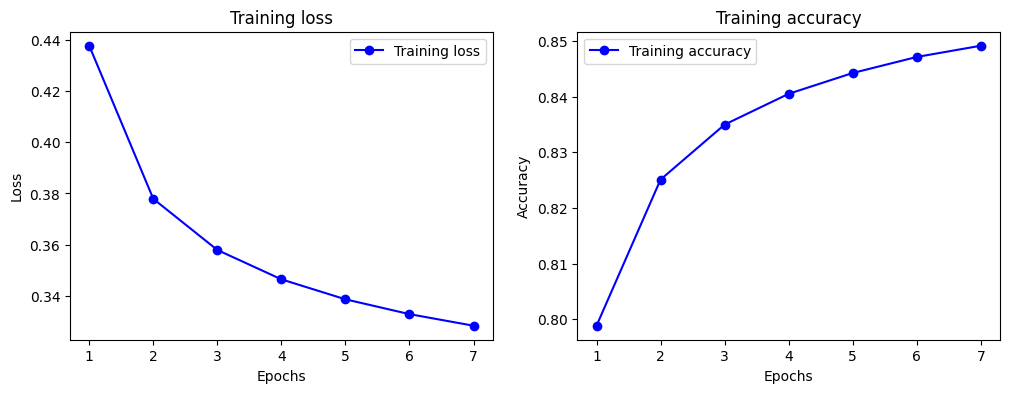

In [33]:
import matplotlib.pyplot as plt

# Step 3: Plot the training history

# Extracting the history data
history_dict = history.history

# Extract loss and accuracy for each epoch
train_loss = history_dict['loss']
train_accuracy = history_dict.get('accuracy')  # Use 'acc' if using older versions of TensorFlow/Keras
# Plot the training loss and accuracy
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()